Answers
-------
1. Autoencoders are mainly used for:
  - Dimensionality reduction
    * We can build an autoencoder that has a hidden layer in the dimensionality that we are interested in.
    * The AE learns the most important features of an input and we can use it as an input with reduced dimensions.
  - Image generation
    * Using variational AEs, a model can learn how to map from Gaussian noise back to an image.
    * We can then feed the model Gaussian noise and get back an image.
  - Noise reduction
    * The encoder adds noise (Gaussian or Dropout) and the decoder learns how to get back to the original input.
  - Unsupervised pre-training
    * Using an AE, we can do a process similar to transfer learning.
    * We train the AE using all the data. The AE maps inputs to themselves through a tight network. Then we copy the weights to a network that's geared towards 
      our task (e.g classifying cats vs dogs) and use only the labeled data.

2. We can use AEs for unsupervised pre-training. See last item in answer 1.

3. Not necessarily. An AE that perfectly reconstructs an image can be due to an identity mapping. We want to squeeze out all the important features during 
  learning and make sure that the AE learns those.
  Evaluating the performance of an AE can be done by measuring how much it learnt the important features of the input. This can be done by measuring the task that the AE is meant to do. For example, if we're using an AE for unsupervised pre-training, we measure the performance of the downstream model (the one that uses the AEs weights).

4. Undercomplete AE - an AE in which the hidden layers dimensions are much smaller than its input. The risk in training such a model is that it won't have 
  enough degrees of freedom to learn the important features of the input.
  Overcomplete AR - an AE in which the hidden layers dimensions are equal or higher than the inputs. The risk of such a model is that it will only learn to 
  copy inputs to outputs and there will not be enough pressure to learn the most important features of the input.

5. 

6. A generative model is one that can generate a never before seen instance that is sampled from the same distribution of the input data. There are 
  different ways to do that but the main idea is to map noise (distribution 1) to the same distribution of the inputs. Variational AEs are generative AEs. They learn to map Gaussian noise to instances that resemble the inputs they were trained on.

7. A GAN (generative adversarial network) is a generative model which learns to generate instances from the same distribution of the inputs it was trained on. It's composed of two networks - generator and a discriminator - that are trained in tandem but also separately.
The generator is tasked with generating images that resemble the inputs and the discriminator learns to discriminate between fake and real instances. 
GANs shine in image generation.

8. Model collapse. The GAN learns to generate and discriminate one class at a time, while forgetting how to generate and discriminate other classes.

9. Diffusion models are generative models that learn to infer which part of an input is noise. Then we can use that noise by subtracting it from an input to get an image. Their main limitation is that they are slow.


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.spatial.transform import Rotation
from sklearn.manifold import TSNE

np.random.seed(42)
tf.random.set_seed(42)

### Exercise 10

Using a denoising autoencoder to pretrain an image classifier.

* Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.
* Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.
* Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

In [2]:
# Getting the data

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [4]:
# Encoder
denoising_encoder = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(0.1),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
])

# Decoder
denoising_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(16 * 16 * 32, activation="relu"),
    tf.keras.layers.Reshape([16, 16, 32]),
    tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="same", activation="sigmoid")
])

# Model
denoising_ae = tf.keras.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10, validation_data=(X_test, X_test))

Epoch 1/10
1563/1563 [==============================] - 40s 25ms/step - loss: 0.5941 - mse: 0.0188 - val_loss: 0.6031 - val_mse: 0.0217
Epoch 2/10
1563/1563 [==============================] - 41s 26ms/step - loss: 0.5729 - mse: 0.0101 - val_loss: 0.5771 - val_mse: 0.0111
Epoch 3/10
1563/1563 [==============================] - 43s 27ms/step - loss: 0.5684 - mse: 0.0083 - val_loss: 0.5736 - val_mse: 0.0099
Epoch 4/10
1563/1563 [==============================] - 44s 28ms/step - loss: 0.5664 - mse: 0.0076 - val_loss: 0.5742 - val_mse: 0.0102
Epoch 5/10
1563/1563 [==============================] - 44s 28ms/step - loss: 0.5652 - mse: 0.0072 - val_loss: 0.5700 - val_mse: 0.0084
Epoch 6/10
1563/1563 [==============================] - 45s 29ms/step - loss: 0.5645 - mse: 0.0069 - val_loss: 0.5685 - val_mse: 0.0080
Epoch 7/10
1563/1563 [==============================] - 46s 29ms/step - loss: 0.5641 - mse: 0.0068 - val_loss: 0.5678 - val_mse: 0.0076
Epoch 8/10
1563/1563 [==========================

1/1 [==============================] - 0s 65ms/step


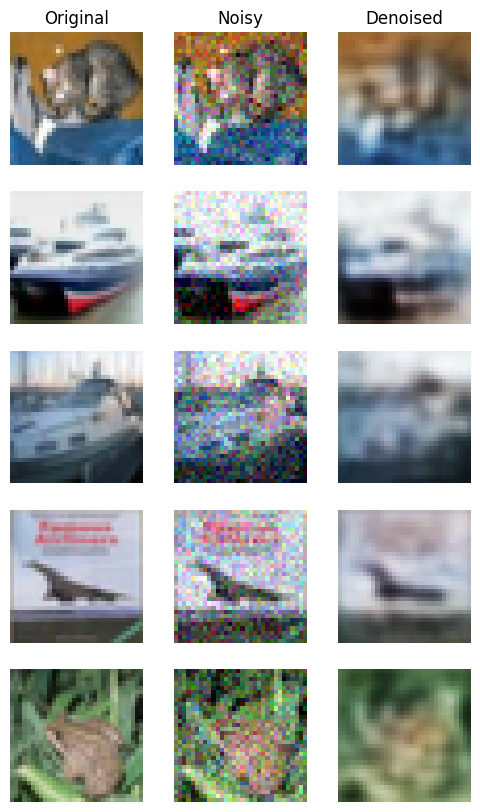

In [5]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(new_images_noisy[index].clip(0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")

plt.show()